# Parameterisation for submesoscale vertical buoyancy flux 

__author__ : Aurélie Albert & Julien Le Sommer (MEOM, IGE)

__contributing author__ : Adekunle Ajayi (MEOM, IGE)

__context__ : 22-GLO-HR project : Lot 1 - Ocean Modelling

__date__ : 8 March 2018

__purpose__ : Metric for the conversion rate of available potential energy to eddy kinetic energy in NATL60-CJM165 simulation

__detailed description__ : 
To quantify the net release of available potential energy, PK in a region, we integrate w’b’ over the
mixed layer depth :

$$\mathcal PK = \frac{1}{h}\int^{-h}_{0} \langle w^{'} b^{'}\rangle_{xy} dz.$$

In the equation above, h, <>xy represents the mixed layer depth, horizontal averaging over a region respectively. Overbar signify large scale flow quantity.

__practical steps__ :

  * Input data are NATL60-CJM165 daily outputs of 3D temperature, salinity and vertical velocities for the months of March and September 2013
  * step 1. : The daily mixed layer depth is computed from 3D T and S fields with cdfmxl cdftool : https://github.com/meom-group/CDFTOOLS : the computation is done on occigen servers
  * step 2. : 3D T, S and W fields are spatially filtered to keep only the fine scales motions with the Lanczos2DHighPassFilter.py script written in the framework of the Vorticity Variance metric (see https://gitlab.com/meom-group-private/cmems-22-glo-hr-codes/tree/master/Task1-fine-scale-metrics/Vorticity-variance) : the computation is done on occigen servers and required parallel computing using mpi facilities developped by Jean-Marc Molines in the framework of the DMONTOOLS (https://github.com/meom-group/CDFTOOLS)
  * step 3. : Daily mixed layer depth field is also spatially filtered to keep only the fine scales contribution
  * step 4. : The horizontal gradient of buoyancy is computed from fine scales 3D fields T and S, multiplied by W and integrated within the mixed layder with a cdftool specially developped for this purpose cdfmxlwb: the computation is done on occigen servers and required parallel computing using mpi facilities  
  * step 5. : 10°x10° boxes already defined in the framework of the Kinetic energy wavenumber spectra are implemented (see https://gitlab.com/meom-group-private/cmems-22-glo-hr-codes/blob/master/Task1-fine-scale-metrics/Wavenumber-spectrum/cmems-glo-hr_demo-fine-scale-metrics_02_kinetic-energy-wavenumber-spectra.ipynb)
  * step 6. : The integrated product of fine scale buoyancy and vertical velocity within the mixed layer is averaged for each box
  * step 7. : Plots of the March and September time series are produced for each box with also the results from the 1st approach
  
__external libraries needed to run this script__ : 

 * Definition of 10°x10° for NATL60 grid :natl60_10_by_10_boxes.py
 * Tools for plot in boxes : plot_box
 
__licence__ : This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

## 0. Importing external modules

In [1]:
## magics

%load_ext version_information 
%version_information numpy,xarray,netCDF4, matplotlib


Software versions
Python 2.7.11 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 4.2.0
OS Linux 3.16.0 4 amd64 x86_64 with debian 8.5
numpy 1.11.2
xarray 0.9.1
netCDF4 1.2.4
matplotlib 2.0.2
Wed Mar 07 16:20:12 2018 CET

In [2]:
## path for modules

import sys
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy.ma as ma

sys.path.insert(0,'/home/albert/lib/python/AJ-spectre/')
from natl60_10_by_10_boxes import boxes
import plot_box as pb

%matplotlib inline
%autosave 60

Autosaving every 60 seconds


## 1. Loading daily outputs of mixed layer depth and fine scale vertical buoyancy flux in the mixed layer

In [47]:
database = '/media/extra/DATA/NATL60/NATL60-CJM165-S/'

mldfiles_march = sorted(glob.glob(database + 'MXL/NATL60-CJM165_y2013m03*_somxl010.nc'))
mxlwbfiles_march = sorted(glob.glob(database + 'mxlwb/NATL60-CJM165_y2013m03*_mxlwbfilt_filt-n80-f0.0125.nc'))

mldfiles_sept = sorted(glob.glob(database + 'MXL/NATL60-CJM165_y2013m09*_somxl010.nc'))
mxlwbfiles_sept = sorted(glob.glob(database + 'mxlwb/NATL60-CJM165_y2013m09*_mxlwbfilt_filt-n80-f0.0125.nc'))

In [48]:
time_mxlwb_march=xr.open_mfdataset(mxlwbfiles_march)['time_counter']
time_mxlwb_sept=xr.open_mfdataset(mxlwbfiles_sept)['time_counter']


## 2. Defining the computation in boxes

In [38]:
def get_values_in_box(box,data):
    jmin,jmax = box.jmin,box.jmax
    imin,imax = box.imin,box.imax
    values = data[jmin:jmax+1,imin:imax+1]
    return values


In [66]:
def Estimate_mxlwb(box,mxlwb,mld):
    mxlwb_box = get_values_in_box(box,mxlwb)
    mld_box = get_values_in_box(box,mld)
    mxlwb_h=mxlwb_box/mld_box
    # - compute average
    avg_mxlwb_box = np.nanmean(mxlwb_h)
    return avg_mxlwb_box

In [67]:
def get_mxlwb_in_boxes(mxlwbfiles,mldfiles):
    global boxes
    _March_mxlwb_arr = []
    for i in range(len(mxlwbfiles)): 
        print mxlwbfiles[i]
        mld = xr.open_dataset(mldfiles[i])['somxl010']
        mxlwb = xr.open_dataset(mxlwbfiles[i])['somxlwb']
        mxlwb = mxlwb.squeeze()
        mld = mld.squeeze()
        _mxlwb_arr = []
        for box in boxes:
            avg_mxlwb_box = Estimate_mxlwb(box,mxlwb,mld)
            _mxlwb_arr.append(avg_mxlwb_box)
        mxlwb_arr = np.array(_mxlwb_arr)
        _March_mxlwb_arr.append(mxlwb_arr)
    March_mxlwb_arr = np.array(_March_mxlwb_arr)
    return March_mxlwb_arr

## 3. Loop on the boxes and the input files

In [68]:
mxlwb_boxes_march = get_mxlwb_in_boxes(mxlwbfiles_march,mldfiles_march)

/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m03d01.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m03d02.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m03d03.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m03d04.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m03d05.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m03d06.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m03d07.1d_mxlwbfilt_filt-n80-f0.0125.nc


/home/albert/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m03d08.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m03d09.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m03d10.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m03d11.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m03d12.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m03d13.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m03d14.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m03d15.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m03d16.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb

In [49]:
mxlwb_boxes_sept = get_mxlwb_in_boxes(mxlwbfiles_sept,mldfiles_sept)

/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m09d01.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m09d02.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m09d03.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m09d04.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m09d05.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m09d06.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m09d07.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m09d08.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb/NATL60-CJM165_y2013m09d09.1d_mxlwbfilt_filt-n80-f0.0125.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/mxlwb

## 4. Time series plots in boxes

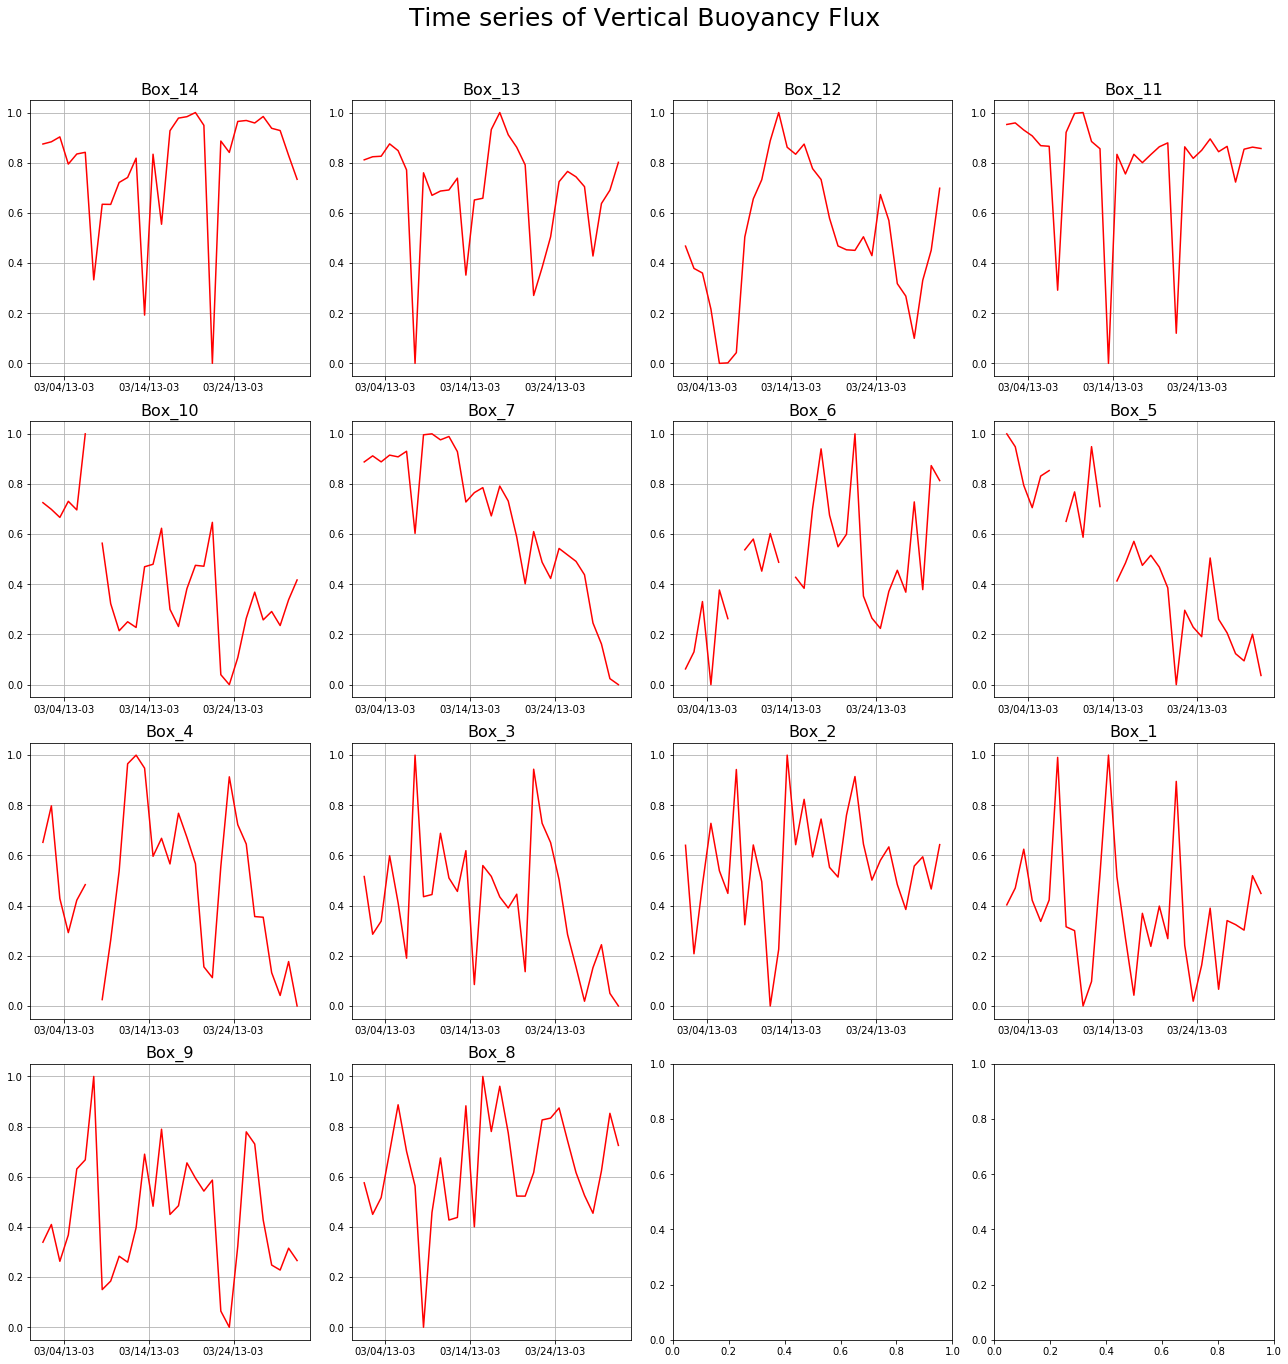

In [69]:
fig, axs = plt.subplots(4,4, figsize=(18, 18))
axs = axs.ravel()
title = 'Time series of Vertical Buoyancy Flux'
plt.suptitle(title,size = 25,y=1.05)
i = 0
for k,box in enumerate(boxes):
    trans_mxlwb_boxes_march=mxlwb_boxes_march[:,k]+(-1)*np.nanmin(mxlwb_boxes_march[:,k])
    max_march=np.nanmax(trans_mxlwb_boxes_march)
    axs[i].plot(time_mxlwb_march,trans_mxlwb_boxes_march/max_march,'r')
    axs[i].set_title(box.name,size=16)
    axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=10))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%D-%m'))
    axs[i].grid(True)
    #axs[i].set_xticklabels(labels)
    i = i + 1
    fig.tight_layout()
    
plt.savefig("NATL60_sub_vert_buoy_flx_param2_march.png")

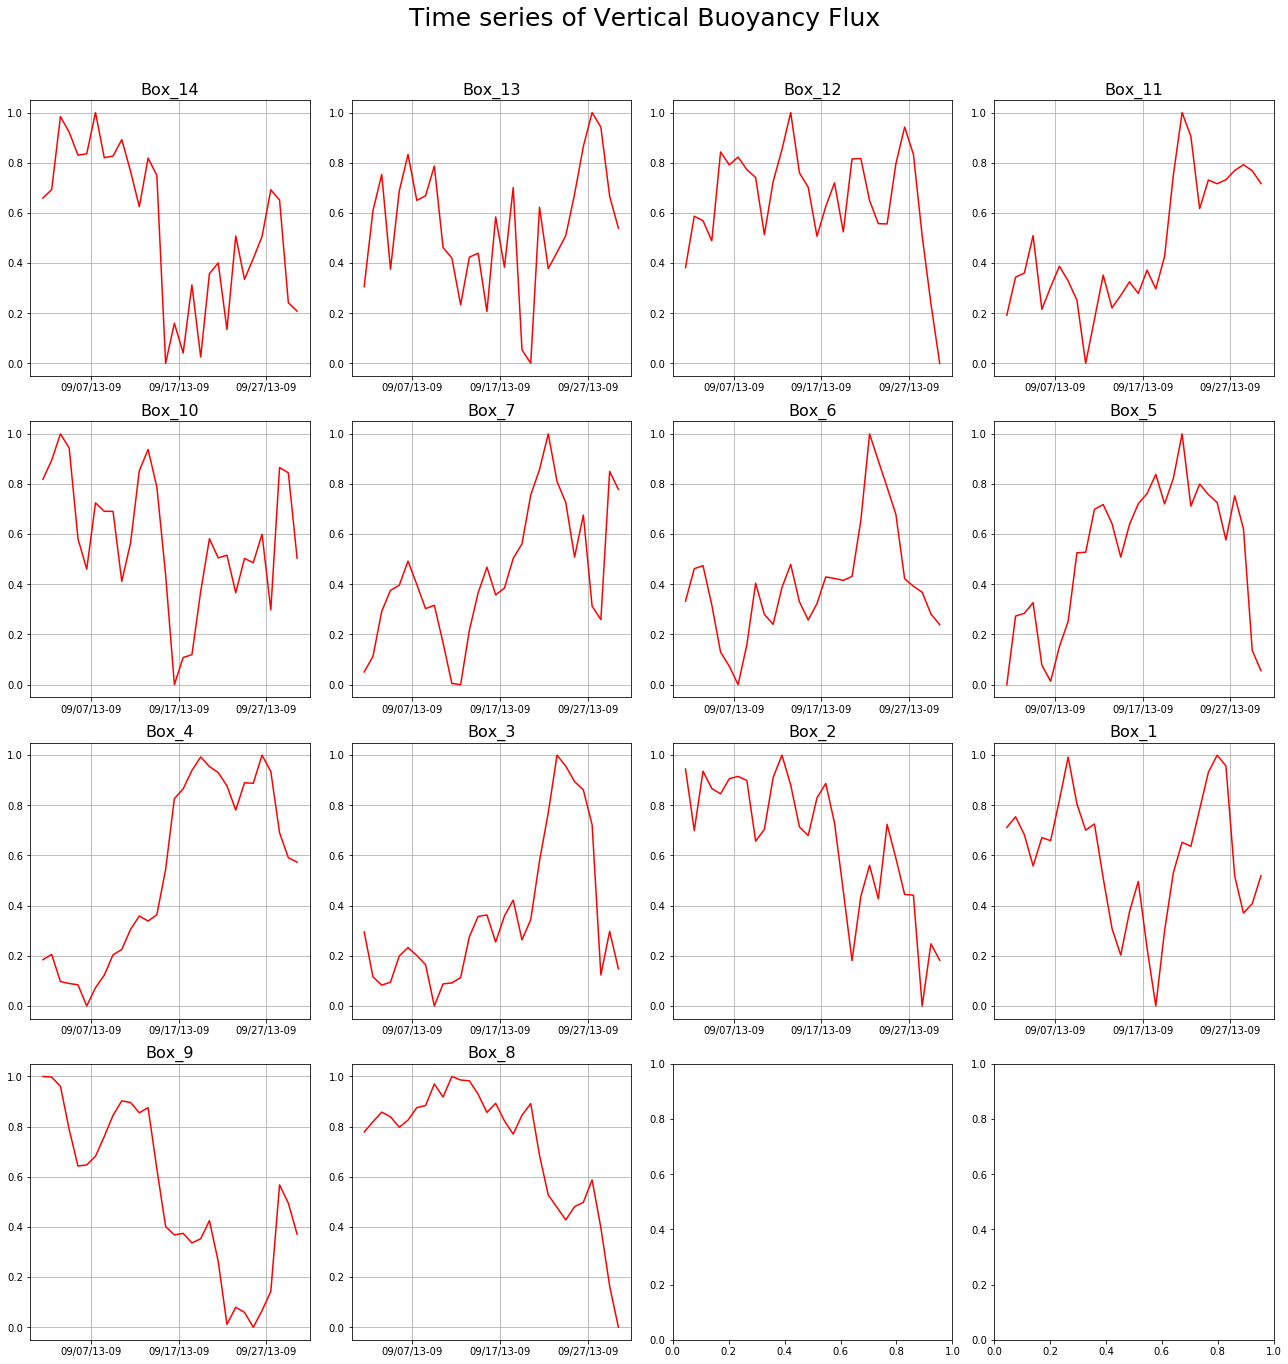

In [53]:
fig, axs = plt.subplots(4,4, figsize=(18, 18))
axs = axs.ravel()
title = 'Time series of Vertical Buoyancy Flux'
plt.suptitle(title,size = 25,y=1.05)
i = 0
for k,box in enumerate(boxes):
    trans_mxlwb_boxes_sept=mxlwb_boxes_sept[:,k]+(-1)*np.nanmin(mxlwb_boxes_sept[:,k])
    max_sept=np.nanmax(trans_mxlwb_boxes_sept)
    axs[i].plot(time_mxlwb_sept,trans_mxlwb_boxes_sept/max_sept,'r')
    axs[i].set_title(box.name,size=16)
    axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=10))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%D-%m'))
    axs[i].grid(True)
    #axs[i].set_xticklabels(labels)
    i = i + 1
    fig.tight_layout()
    
plt.savefig("NATL60_sub_vert_buoy_flx_param2_sept.png")

## 5. Comparaison of the two methods

In [23]:
gradbfiles = sorted(glob.glob(database + 'hgrad-large-scale/NATL60-CJM165_y2*_hgradb_large_scale.nc'))
time_counter=xr.open_mfdataset(mldfiles)['time_counter']
def get_values_in_box(box,data):
    jmin,jmax = box.jmin,box.jmax
    imin,imax = box.imin,box.imax
    values = data[jmin:jmax+1,imin:imax+1]
    return values
def Estimate_wb(box,mld,gradb):
    mld_box = get_values_in_box(box,mld)
    gradb_box = get_values_in_box(box,gradb)    
    # - compute average
    avg_mld_box = mld_box.mean()
    avg_gradb_box = gradb_box.mean()
    # - compute w'b'
    wb_box = (avg_mld_box*avg_gradb_box)**2
    return wb_box
def get_wb_in_boxes(mldfiles,gradbfiles):
    global boxes
    _Ann_wb_arr = []
    for i in range(len(gradbfiles)): 
        if i%30 == 0: print mldfiles[i]
        mld = xr.open_dataset(mldfiles[i])['somxl010']
        gradb = xr.open_dataset(gradbfiles[i])['vohgradb']
        mld = mld.squeeze() ; gradb = gradb.squeeze();
        _wb_arr = []
        for box in boxes:
            wb = Estimate_wb(box,mld,gradb)
            _wb_arr.append(wb)
        wb_arr = np.array(_wb_arr)
        _Ann_wb_arr.append(wb_arr)
    Ann_wb_arr = np.array(_Ann_wb_arr)
    return Ann_wb_arr
wb_boxes_yr = get_wb_in_boxes(mldfiles,gradbfiles)


/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2012m10d01.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2012m10d31.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2012m11d30.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2012m12d30.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m01d29.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m02d28.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m03d30.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m04d29.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m05d29.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m06d28.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJM165_y2013m07d28.1d_somxl010.nc
/media/extra/DATA/NATL60/NATL60-CJM165-S/MXL/NATL60-CJ

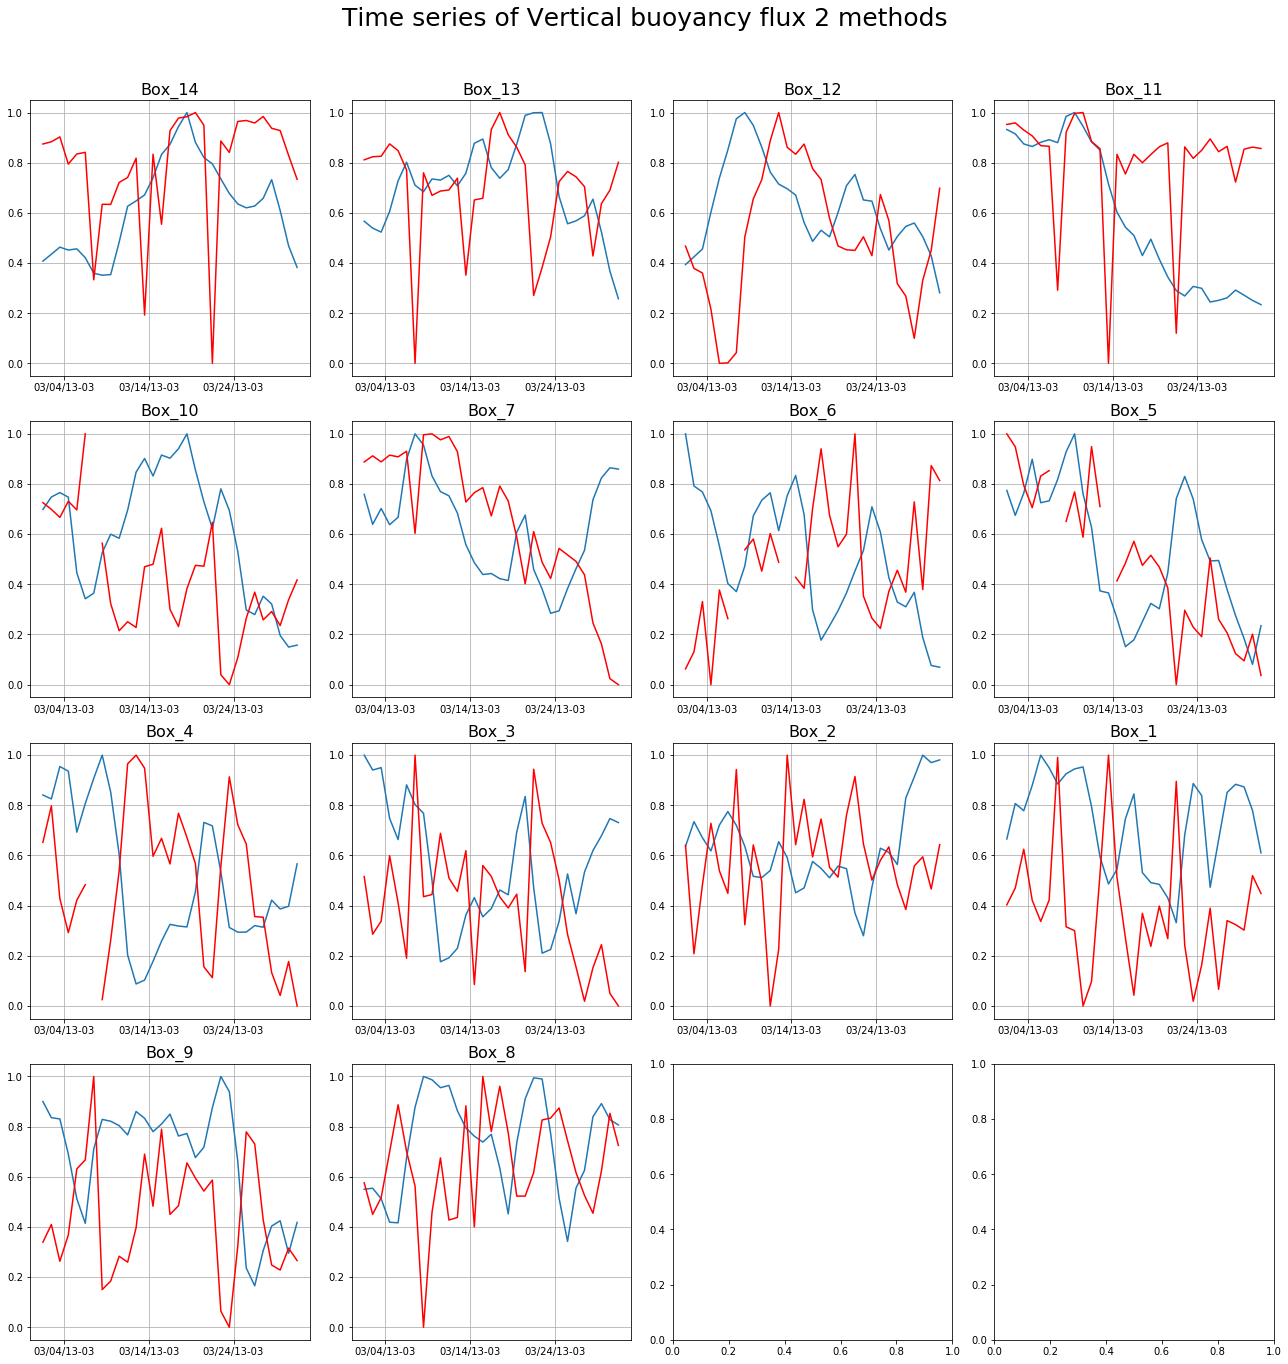

In [54]:
fig, axs = plt.subplots(4,4, figsize=(18, 18))
axs = axs.ravel()
title = 'Time series of Vertical buoyancy flux 2 methods'
plt.suptitle(title,size = 25,y=1.05)
i = 0
for k,box in enumerate(boxes):
    maxt=np.nanmax(wb_boxes_yr[151:182,k])
    axs[i].plot(time_mxlwb_march,wb_boxes_yr[151:182,k]/maxt)
    trans_mxlwb_boxes_march=mxlwb_boxes_march[:,k]+(-1)*np.nanmin(mxlwb_boxes_march[:,k])
    max_march=np.nanmax(trans_mxlwb_boxes_march)
    axs[i].plot(time_mxlwb,trans_mxlwb_boxes_march/max_march,'r')
    axs[i].set_title(box.name,size=16)
    axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=10))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%D-%m'))
    axs[i].grid(True)
    #axs[i].set_xticklabels(labels)
    i = i + 1
    fig.tight_layout()
    
plt.savefig("NATL60_sub_vert_buoy_flx_param2_march.png")

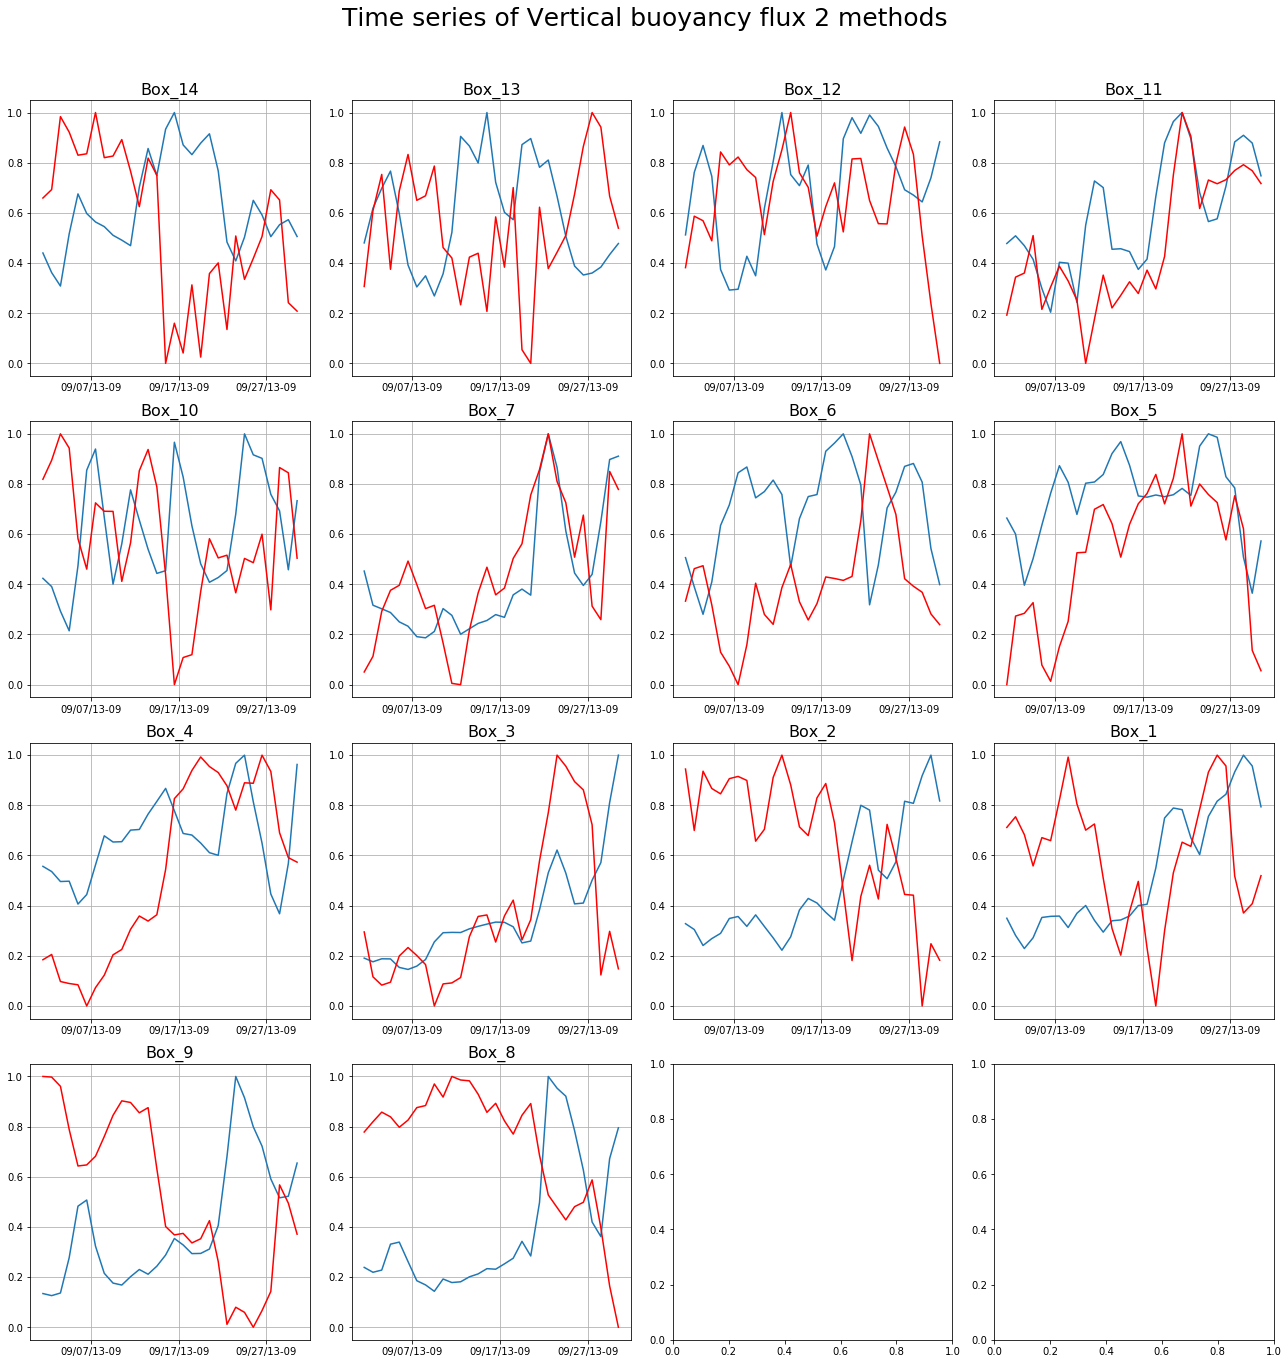

In [65]:
fig, axs = plt.subplots(4,4, figsize=(18, 18))
axs = axs.ravel()
title = 'Time series of Vertical buoyancy flux 2 methods'
plt.suptitle(title,size = 25,y=1.05)
i = 0
for k,box in enumerate(boxes):
    maxt=np.nanmax(wb_boxes_yr[335:365,k])
    axs[i].plot(time_mxlwb_sept,wb_boxes_yr[335:365,k]/maxt)
    trans_mxlwb_boxes_sept=mxlwb_boxes_sept[:,k]+(-1)*np.nanmin(mxlwb_boxes_sept[:,k])
    max_sept=np.nanmax(trans_mxlwb_boxes_sept)
    axs[i].plot(time_mxlwb_sept,trans_mxlwb_boxes_sept/max_sept,'r')
    axs[i].set_title(box.name,size=16)
    axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=10))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%D-%m'))
    axs[i].grid(True)
    #axs[i].set_xticklabels(labels)
    i = i + 1
    fig.tight_layout()
    
plt.savefig("NATL60_sub_vert_buoy_flx_param2_sept.png")